In [1]:
from matplotlib.path import Path
import matplotlib.pyplot as plt
import numpy as np

import cartopy.crs as ccrs
from cartopy.io.img_tiles import OSM
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader
import cartopy.geodesic as cgeo

import os

import cartopy.io.img_tiles as cimgt
import io
from urllib.request import urlopen, Request
from PIL import Image
import shapely

In [3]:
stations = np.load("../data/stations.npz")
lats = stations["lats"]
lons = stations["lons"]
ids = stations["ids"]

In [4]:
def image_spoof(self, tile):
    '''this function reformats web requests from OSM for cartopy
    Heavily based on code by Joshua Hrisko at:
        https://makersportal.com/blog/2020/4/24/geographic-visualizations-in-python-with-cartopy'''

    url = self._image_url(tile)                # get the url of the street map API
    req = Request(url)                         # start request
    req.add_header('User-agent','Anaconda 3')  # add user agent to request
    fh = urlopen(req) 
    im_data = io.BytesIO(fh.read())            # get image
    fh.close()                                 # close url
    img = Image.open(im_data)                  # open image with PIL
    img = img.convert(self.desired_tile_form)  # set image format
    return img, self.tileextent(tile), 'lower' # reformat for cartopy

In [5]:
def calc_extent(lon,lat,dist):
    '''This function calculates extent of map
    Inputs:
        lat,lon: location in degrees
        dist: dist to edge from centre
    '''

    dist_cnr = np.sqrt(2*dist**2)
    top_left = cgeo.Geodesic().direct(points=(lon,lat),azimuths=-45,distances=dist_cnr)[:,0:2][0]
    bot_right = cgeo.Geodesic().direct(points=(lon,lat),azimuths=135,distances=dist_cnr)[:,0:2][0]

    extent = [top_left[0], bot_right[0], bot_right[1], top_left[1]]

    return extent

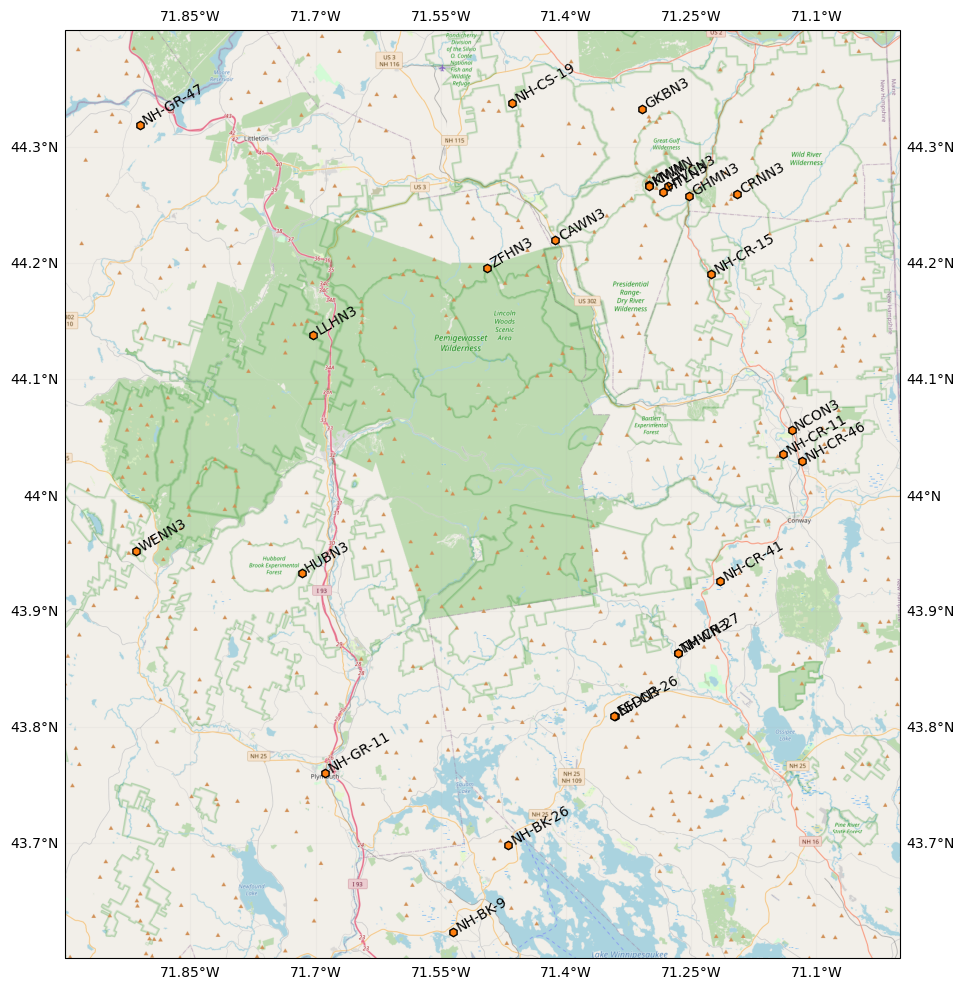

In [7]:
lonmin = -72
lonmax = -71
latmin = 43.6
latmax = 44.4

cimgt.OSM.get_image = image_spoof  # reformat web request for street map spoofing
img = cimgt.OSM()                  # spoofed, downloaded street map

# cimgt.QuadtreeTiles.get_image = image_spoof # reformat web request for street map spoofing
# img = cimgt.QuadtreeTiles() # spoofed, downloaded street map

fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection=img.crs) # project using coordinate reference system (CRS) of street map
data_crs = ccrs.PlateCarree()
ax.set_extent([lonmin, lonmax, latmin, latmax], ccrs.PlateCarree())

scale = 11

# extent = calc_extent(lon,lat,radius*1.1)
# ax.set_extent(extent) # set extents
ax.add_image(img, int(scale)) # add OSM with zoom specification

# ax.coastlines()
# ax.add_feature(cfeature.BORDERS, linestyle='-', lw=0.5)
# ax.add_feature(cfeature.LAKES, alpha=0.5)
# ax.add_feature(cfeature.RIVERS)

ax.gridlines(draw_labels=True,alpha=0.1)

ax.plot(lons, lats, transform=ccrs.PlateCarree(),
        marker='h', color='C1', markersize=6, linestyle='', markeredgecolor='k')

dxy = 0.001
for (id,lon,lat) in zip(ids,lons,lats):
    if lon > lonmin and lon < lonmax and lat > latmin and lat < latmax:
        ax.text(lon+dxy,lat+dxy, id, transform=ccrs.PlateCarree(), rotation=30)

# ax.set_title('Snowpack stations')
plt.tight_layout()
plt.show()